<a href="https://colab.research.google.com/github/kkoma2623/VisualComputing/blob/master/Fashion_MNIST_AutoEncoder_20143109.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import tensorflow and additional libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.keras.backend.clear_session()

# Check version
print('tensorflow version: ', tf.__version__)

tensorflow version:  2.2.0


In [ ]:
# Load : Fashion MNIST Dataest
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train  = len(x_train)
size_of_test  = len(x_test)
num_of_class = 10

print('The Shape of dataset:', x_train[0].shape)
print('The number of train image:', size_of_train)
print('The number of test image:', size_of_test)

4423680/4422102 [==============================] - 0s 0us/step
The Shape of dataset: (28, 28)
The number of train image: 60000
The number of test image: 10000


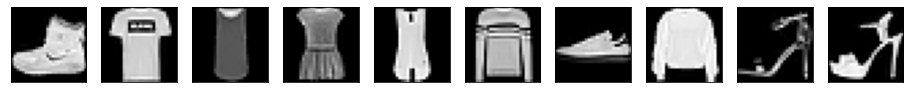

In [ ]:
# Train Data
plt.figure(figsize=(16, 10))
for i in range(num_of_class):
    ax = plt.subplot(1, num_of_class, i+1)
    plt.imshow(x_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
print('== Before normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

## Dataset Pre-processing ##
# Normalization
x_train = x_train/255.  
x_test = x_test/255. 

# Reshape(Adding channel)
x_train = x_train.reshape((size_of_train, 28, 28, 1))
x_test = x_test.reshape((size_of_test, 28, 28, 1))

print('\n== After normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

== Before normalization ==
Image Shape: (28, 28)
Value MIN: 0, MEAN:97.25, MAX:255

== After normalization ==
Image Shape: (28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1


In [ ]:
def channel_attention(x, channels, name):
    ####Fill your code####
    F_in = x
    r = 4
    F_in = tf.keras.layers.GlobalAveragePooling2D()(F_in)               # 64 vec
    F_in = tf.keras.layers.Dense(channels//r)(F_in)                     # 16 vec => (64/4)
    F_in = tf.keras.layers.BatchNormalization()(F_in)
    F_in = tf.keras.layers.ReLU()(F_in)                                 # relu
    F_in = tf.keras.layers.Dense(channels, activation='sigmoid')(F_in)  # 64 vec and sigmoid
    F_out = x * F_in[:, None, None]

    return  F_out

def spatial_attention(x, channels, name):
    ####Fill your code####
    F_in = x
    r = 4
    F_in = tf.keras.layers.Conv2D(filters=channels//r, kernel_size=1, strides=(1,1), padding='same')(F_in)
    F_in = tf.keras.layers.BatchNormalization()(F_in)
    F_in = tf.keras.layers.ReLU()(F_in)
    F_in = tf.keras.layers.Conv2D(filters=channels//r, kernel_size=3, strides=(1,1), padding='same')(F_in)
    F_in = tf.keras.layers.BatchNormalization()(F_in)
    F_in = tf.keras.layers.ReLU()(F_in)
    F_in = tf.keras.layers.Conv2D(filters=channels//r, kernel_size=3, strides=(1,1), padding='same')(F_in)
    F_in = tf.keras.layers.BatchNormalization()(F_in)
    F_in = tf.keras.layers.ReLU()(F_in)
    F_in = tf.keras.layers.Conv2D(1, kernel_size=1, strides=(1,1), padding='same', activation='sigmoid')(F_in)
    F_out = x * F_in

    return  F_out
 
def autoencoder_block(x, filter, name): 
    x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3, strides=(1, 1), padding='same', name=name+'_conv')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn')(x)
    x = tf.keras.layers.ReLU(name=name+'_relu')(x)
    return x

In [ ]:
##############################################
# Add Attention Block in AutoEncoder network #
##############################################

def autoencoder(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img

def autoencoder_channel(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    
    x = channel_attention(x, 16, 'channel_attention1')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = channel_attention(x, 32, 'channel_attention2')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = channel_attention(x, 64, 'channel_attention3')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')

    x = channel_attention(x, 32, 'channel_attention4')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    


In [ ]:
# Normal AutoEncoder Model Create / Summary
input_data = tf.keras.Input(shape=(28, 28, 1))

output_data = autoencoder(input_data)
output_channel_data = autoencoder_channel(input_data)

model = tf.keras.Model(inputs=input_data, outputs=output_data)
model_channel  = tf.keras.Model(inputs=input_data, outputs=output_channel_data)

model.summary()
model_channel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder1_conv (Conv2D)       (None, 28, 28, 16)        160       
_________________________________________________________________
encoder1_bn (BatchNormalizat (None, 28, 28, 16)        64        
_________________________________________________________________
encoder1_relu (ReLU)         (None, 28, 28, 16)        0         
_________________________________________________________________
encoder_pool1 (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
encoder2_conv (Conv2D)       (None, 14, 14, 32)        4640      
_________________________________________________________________
encoder2_bn (BatchNormalizat (None, 14, 14, 32)        128   

In [ ]:
# Model Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
model_channel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [ ]:
# Training
print('Training Model')
epoch = 25
# AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
history = model.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_channel = model_channel.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model
Epoch 1/25
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/25
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/25
3750/3750 [==============================] - 16s 4ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 4/25
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 5/25
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 6/25
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/25
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 8/25
3750/3750 [==================

In [ ]:
def autoencoder_spatial(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    
    x = spatial_attention(x, 16, 'spatial_attention1')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = spatial_attention(x, 32, 'spatial_attention2')
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = spatial_attention(x, 64, 'spatial_attention3')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')

    x = spatial_attention(x, 32, 'spatial_attention4')
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img   

In [ ]:
# Normal AutoEncoder Model Create / Summary
input_autoencoder_spatial_data = tf.keras.Input(shape=(28, 28, 1))

output_autoencoder_spatial_data = autoencoder_spatial(input_autoencoder_spatial_data)

model_autoencoder_spatial  = tf.keras.Model(inputs=input_autoencoder_spatial_data, outputs=output_autoencoder_spatial_data)

model_autoencoder_spatial.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder1_conv (Conv2D)          (None, 28, 28, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
encoder1_bn (BatchNormalization (None, 28, 28, 16)   64          encoder1_conv[0][0]              
__________________________________________________________________________________________________
encoder1_relu (ReLU)            (None, 28, 28, 16)   0           encoder1_bn[0][0]                
____________________________________________________________________________________________

In [ ]:
# Model Compile
model_autoencoder_spatial.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [ ]:
# Training
print('Training Model - autoencoder-spatial')
epoch = 25
# AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
history_autoencoder_spatial = model_autoencoder_spatial.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model - autoencoder-spatial
Epoch 1/25
3750/3750 [==============================] - 31s 8ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 2/25
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 3/25
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/25
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 5/25
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 6/25
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/25
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 8/25
3750/37

In [ ]:
def autoencoder_parallel_add(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    
    x_channel = channel_attention(x, 16, 'channel_attention')
    x_spatial = spatial_attention(x, 16, 'spatial_attention')
    x = tf.keras.layers.add([x_channel, x_spatial])
    
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x_channel = channel_attention(x, 32, 'channel_attention2')
    x_spatial = spatial_attention(x, 32, 'spatial_attention2')
    x = tf.keras.layers.add([x_channel, x_spatial])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x_channel = channel_attention(x, 64, 'channel_attention3')
    x_spatial = spatial_attention(x, 64, 'spatial_attention3')
    x = tf.keras.layers.add([x_channel, x_spatial])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')

    x_channel = channel_attention(x, 32, 'channel_attention4')
    x_spatial = spatial_attention(x, 32, 'spatial_attention4')
    x = tf.keras.layers.add([x_channel, x_spatial])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img   

In [ ]:
# Normal AutoEncoder Model Create / Summary
input_autoencoder_parallel_add_data = tf.keras.Input(shape=(28, 28, 1))

output_autoencoder_parallel_add_data = autoencoder_parallel_add(input_autoencoder_parallel_add_data)

model_autoencoder_parallel_add  = tf.keras.Model(inputs=input_autoencoder_parallel_add_data, outputs=output_autoencoder_parallel_add_data)

model_autoencoder_parallel_add.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder1_conv (Conv2D)          (None, 28, 28, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
encoder1_bn (BatchNormalization (None, 28, 28, 16)   64          encoder1_conv[0][0]              
__________________________________________________________________________________________________
encoder1_relu (ReLU)            (None, 28, 28, 16)   0           encoder1_bn[0][0]                
____________________________________________________________________________________________

In [ ]:
# Model Compile
model_autoencoder_parallel_add.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [ ]:
# Training
print('Training Model - autoencoder_parallel_add')
epoch = 25
# AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
history_autoencoder_parallel_add = model_autoencoder_parallel_add.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model - autoencoder_parallel_add
Epoch 1/25
3750/3750 [==============================] - 39s 10ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 2/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 3/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 4/25
3750/3750 [==============================] - 39s 10ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/25
3750/3750 [==============================] - 39s 10ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 7/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 

In [ ]:
def autoencoder_parallel_mul(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    
    x_channel = channel_attention(x, 16, 'channel_attention')
    x_spatial = spatial_attention(x, 16, 'spatial_attention')
    x = tf.keras.layers.Multiply()([x_channel, x_spatial])
    
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x_channel = channel_attention(x, 32, 'channel_attention2')
    x_spatial = spatial_attention(x, 32, 'spatial_attention2')
    x = tf.keras.layers.Multiply()([x_channel, x_spatial])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x_channel = channel_attention(x, 64, 'channel_attention3')
    x_spatial = spatial_attention(x, 64, 'spatial_attention3')
    x = tf.keras.layers.Multiply()([x_channel, x_spatial])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')

    x_channel = channel_attention(x, 32, 'channel_attention4')
    x_spatial = spatial_attention(x, 32, 'spatial_attention4')
    x = tf.keras.layers.Multiply()([x_channel, x_spatial])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img   

In [ ]:
# Normal AutoEncoder Model Create / Summary
input_autoencoder_parallel_mul_data = tf.keras.Input(shape=(28, 28, 1))

output_autoencoder_parallel_mul_data = autoencoder_parallel_mul(input_autoencoder_parallel_mul_data)

model_autoencoder_parallel_mul  = tf.keras.Model(inputs=input_autoencoder_parallel_mul_data, outputs=output_autoencoder_parallel_mul_data)

model_autoencoder_parallel_mul.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder1_conv (Conv2D)          (None, 28, 28, 16)   160         input_4[0][0]                    
__________________________________________________________________________________________________
encoder1_bn (BatchNormalization (None, 28, 28, 16)   64          encoder1_conv[0][0]              
__________________________________________________________________________________________________
encoder1_relu (ReLU)            (None, 28, 28, 16)   0           encoder1_bn[0][0]                
____________________________________________________________________________________________

In [ ]:
# Model Compile
model_autoencoder_parallel_mul.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [ ]:
# Training
print('Training Model - autoencoder_parallel_mul')
epoch = 25
# AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
history_autoencoder_parallel_mul = model_autoencoder_parallel_mul.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model - autoencoder_parallel_mul
Epoch 1/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 2/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 3/25
3750/3750 [==============================] - 39s 10ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 4/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 5/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 6/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 

In [ ]:
def autoencoder_serial_channel_first(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    
    x = channel_attention(x, 16, 'channel_attention')
    x = spatial_attention(x, 16, 'spatial_attention')
    
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = channel_attention(x, 32, 'channel_attention2')
    x = spatial_attention(x, 32, 'spatial_attention2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = channel_attention(x, 64, 'channel_attention3')
    x = spatial_attention(x, 64, 'spatial_attention3')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')

    x = channel_attention(x, 32, 'channel_attention4')
    x = spatial_attention(x, 32, 'spatial_attention4')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img   

In [ ]:
# Normal AutoEncoder Model Create / Summary
input_autoencoder_serial_channel_first_data = tf.keras.Input(shape=(28, 28, 1))

output_autoencoder_serial_channel_first_data = autoencoder_serial_channel_first(input_autoencoder_serial_channel_first_data)

model_autoencoder_serial_channel_first  = tf.keras.Model(inputs=input_autoencoder_serial_channel_first_data, outputs=output_autoencoder_serial_channel_first_data)

model_autoencoder_serial_channel_first.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder1_conv (Conv2D)          (None, 28, 28, 16)   160         input_5[0][0]                    
__________________________________________________________________________________________________
encoder1_bn (BatchNormalization (None, 28, 28, 16)   64          encoder1_conv[0][0]              
__________________________________________________________________________________________________
encoder1_relu (ReLU)            (None, 28, 28, 16)   0           encoder1_bn[0][0]                
____________________________________________________________________________________________

In [ ]:
# Model Compile
model_autoencoder_serial_channel_first.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [ ]:
# Training
print('Training Model - autoencoder_serial_channel_first')
epoch = 25
# AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
history_autoencoder_serial_channel_first = model_autoencoder_serial_channel_first.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model - autoencoder_serial_channel_first
Epoch 1/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/25
3750/3750 [==============================] - 39s 10ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 4/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 5/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 7/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0020 - val_mse: 0.002

In [ ]:
def autoencoder_serial_spatial_first(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    
    x = spatial_attention(x, 16, 'spatial_attention')
    x = channel_attention(x, 16, 'channel_attention')
    
    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = spatial_attention(x, 32, 'spatial_attention2')
    x = channel_attention(x, 32, 'channel_attention2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = spatial_attention(x, 64, 'spatial_attention3')
    x = channel_attention(x, 64, 'channel_attention3')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')

    x = spatial_attention(x, 32, 'spatial_attention4')
    x = channel_attention(x, 32, 'channel_attention4')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img   

In [ ]:
# Normal AutoEncoder Model Create / Summary
input_autoencoder_serial_spatial_first_data = tf.keras.Input(shape=(28, 28, 1))

output_autoencoder_serial_spatial_first_data = autoencoder_serial_spatial_first(input_autoencoder_serial_spatial_first_data)

model_autoencoder_serial_spatial_first  = tf.keras.Model(inputs=input_autoencoder_serial_spatial_first_data, outputs=output_autoencoder_serial_spatial_first_data)

model_autoencoder_serial_spatial_first.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder1_conv (Conv2D)          (None, 28, 28, 16)   160         input_6[0][0]                    
__________________________________________________________________________________________________
encoder1_bn (BatchNormalization (None, 28, 28, 16)   64          encoder1_conv[0][0]              
__________________________________________________________________________________________________
encoder1_relu (ReLU)            (None, 28, 28, 16)   0           encoder1_bn[0][0]                
____________________________________________________________________________________________

In [ ]:
# Model Compile
model_autoencoder_serial_spatial_first.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [ ]:
# Training
print('Training Model - autoencoder_serial_spatial_first')
epoch = 25
# AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
history_autoencoder_serial_spatial_first = model_autoencoder_serial_spatial_first.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=epoch,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model - autoencoder_serial_spatial_first
Epoch 1/25
3750/3750 [==============================] - 37s 10ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 2/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/25
3750/3750 [==============================] - 38s 10ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 4/25
3750/3750 [==============================] - 37s 10ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/25
3750/3750 [==============================] - 37s 10ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 6/25
3750/3750 [==============================] - 37s 10ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 7/25
3750/3750 [==============================] - 37s 10ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0019 - val_mse: 0.001

In [ ]:
# Model Predict
recons = model.predict(x_test)
recons_channel = model_channel.predict(x_test)
recons_autoencoder_spatial = model_autoencoder_spatial.predict(x_test)
recons_autoencoder_parallel_add = model_autoencoder_parallel_add.predict(x_test)
recons_autoencoder_parallel_mul = model_autoencoder_parallel_mul.predict(x_test)
recons_autoencoder_serial_channel_first = model_autoencoder_serial_channel_first.predict(x_test)
recons_autoencoder_serial_spatial_first = model_autoencoder_serial_spatial_first.predict(x_test)

In [ ]:
recons = recons.reshape(-1, 28, 28)
recons_channel = recons_channel.reshape(-1, 28, 28)
recons_autoencoder_spatial = recons_autoencoder_spatial.reshape(-1, 28, 28)
recons_autoencoder_parallel_add = recons_autoencoder_parallel_add.reshape(-1, 28, 28)
recons_autoencoder_parallel_mul = recons_autoencoder_parallel_mul.reshape(-1, 28, 28)
recons_autoencoder_serial_channel_first = recons_autoencoder_serial_channel_first.reshape(-1, 28, 28)
recons_autoencoder_serial_spatial_first = recons_autoencoder_serial_spatial_first.reshape(-1, 28, 28)

test_imgs = (x_test * 255).reshape(-1, 28, 28)

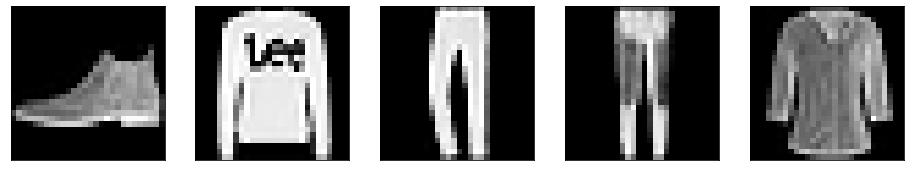

In [ ]:
# Test Data Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(test_imgs[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

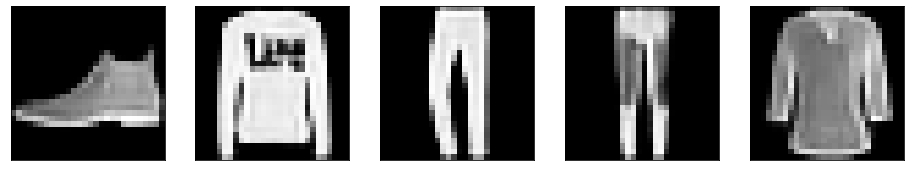

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

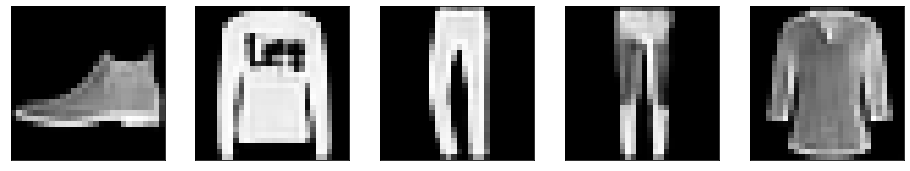

In [ ]:
# Predictions Visualization - channel
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_channel[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

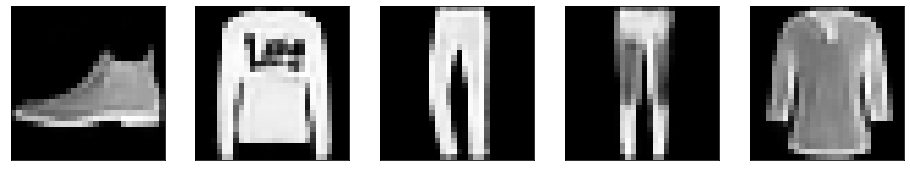

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_autoencoder_spatial[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

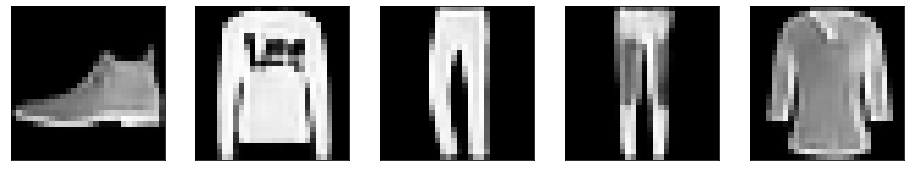

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_autoencoder_parallel_add[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

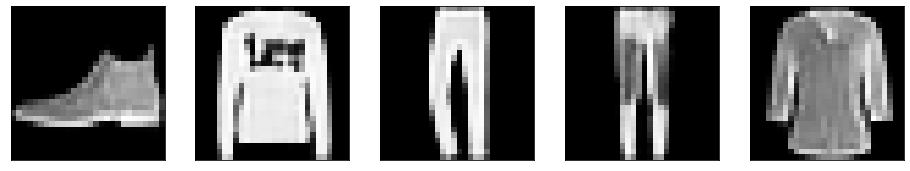

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_autoencoder_parallel_mul[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

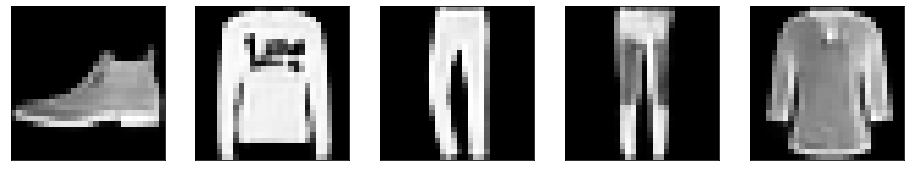

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_autoencoder_serial_channel_first[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

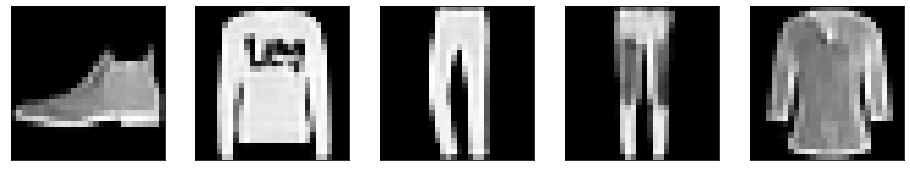

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_autoencoder_serial_spatial_first[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

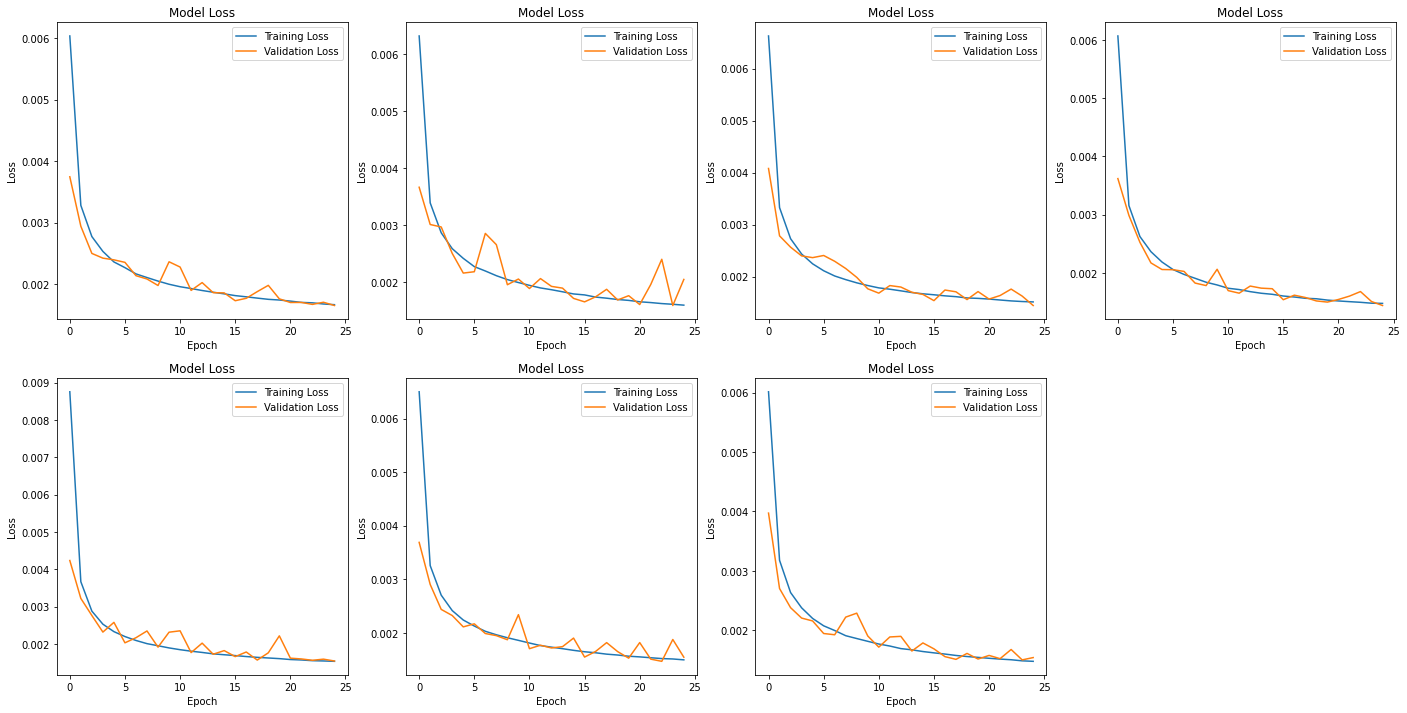

In [ ]:
plt.figure(figsize=(24, 12))

plt.subplot(2,4,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,2)
plt.plot(history_channel.history['loss'])
plt.plot(history_channel.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,3)
plt.plot(history_autoencoder_spatial.history['loss'])
plt.plot(history_autoencoder_spatial.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,4)
plt.plot(history_autoencoder_parallel_add.history['loss'])
plt.plot(history_autoencoder_parallel_add.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,5)
plt.plot(history_autoencoder_parallel_mul.history['loss'])
plt.plot(history_autoencoder_parallel_mul.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,6)
plt.plot(history_autoencoder_serial_channel_first.history['loss'])
plt.plot(history_autoencoder_serial_channel_first.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,7)
plt.plot(history_autoencoder_serial_spatial_first.history['loss'])
plt.plot(history_autoencoder_serial_spatial_first.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()